# Model 4: Biased transmission (indirect bias)

original: https://bookdown.org/amesoudi/ABMtutorial_bookdown/model4.html

### Note

- Certain demonstrators are more likely to be copied than other demonstrators.
- For this reason, indirect bias is sometimes called ‘demonstrator-based’ or ‘context’ bias.
- Learners might preferentially copy
    - demonstrators who have high success or payoffs (which may or may not derive from their cultural traits),
    - demonstrators who are old (and perhaps have accrued valuable knowledge, or at least good enough to keep them alive to old age),
    - demonstrators who are the same gender as the learner (if cultural traits are gender-specific), or
    - demonstrators who possess high social status or prestige.

## Model 4a: Payoff bias

In [1]:
include("src/Agent.jl")
include("src/Output.jl")
using .Agent
using .Output

using StatsBase

In [2]:
function biased_transmission(; N::Int64, r_max::Int64, t_max::Int64, p_0::Float64, s::Float64)
    # N: population
    # r_max: number of independent runs
    # t_max: max of generations (t)
    # p_0: the initial proportion of A
    # s: the strength of biased transmission
    output_df = make_output_df(r_max, t_max)

    for r = 1:r_max
        agent_df = make_agent_df(N, p_0, s)

        for t = 1:t_max
            if t > 1
                agent_df.trait = sample(agent_df.trait, ProbabilityWeights(agent_df.payoff), N)
                agent_df.payoff = [t == A ? 1.0 + s : 1.0 for t in agent_df.trait]
            end

            # get p and put it into the output slot for this generation t
            row_num = t + (r - 1) * t_max
            output_df.r[row_num] = r
            output_df.t[row_num] = t
            output_df.p[row_num] = trait_ratio(agent_df, A)
        end
    end
    
    plot_A(output_df, "N = $N, p_0 = $p_0, s = $s")
end;

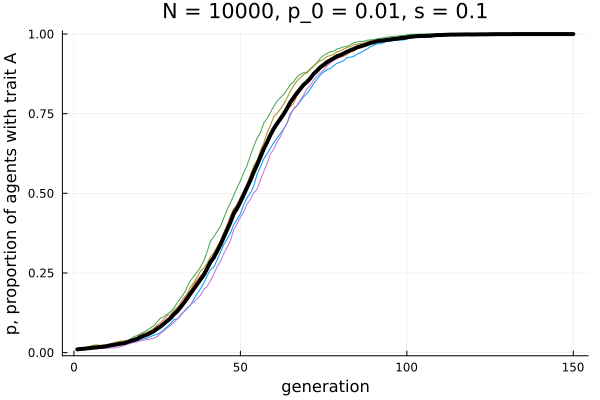

In [3]:
biased_transmission(N = 10^4, r_max = 5, t_max = 150, p_0 = 0.01, s = 0.1)

### Note

- Given that in Model 4a an agent’s payoff is entirely determined by their cultural trait.
- Under these assumptions, preferentially copying high payoff agents is functionally equivalent to preferentially copying high payoff traits (Model 3).

## Model 4b: Cultural hitch-hiking

### Note

- individuals possess two cultural traits, one functional (A / B) and the other neutral (X / Y).
- $p$: probability of $A$ ($1 - p$: $B$).
- $q$: probability of $X$ ($1 - q$: $Y$).
- We will model a situation where the two traits may be initially linked.
- We define a parameter $L$ that specifies the probability in the initial generation that, if an individual has an $A$ for trait 1, they also have an $X$ for trait 2.


In [4]:
function biased_transmission(; N::Int64, r_max::Int64, t_max::Int64, p_0::Float64, q_0::Float64, L::Float64, s::Float64)
    output_df = make_output_df(r_max, t_max)

    for r = 1:r_max
        agent_df = make_agent_df(N, p_0, q_0, L, s)

        for t = 1:t_max
            if t > 1
                demonstrators = sample(1:N, ProbabilityWeights(agent_df.payoff), N)
                agent_df.trait = [agent_df.trait[d] for d in demonstrators]
                agent_df.trait2 = [agent_df.trait2[d] for d in demonstrators]
                agent_df.payoff = [t == A ? 1.0 + s : 1.0 for t in agent_df.trait]
            end

            # get p and put it into the output slot for this generation t
            row_num = t + (r - 1) * t_max
            output_df.r[row_num] = r
            output_df.t[row_num] = t
            output_df.p[row_num] = trait_ratio(agent_df, A)
            output_df.q[row_num] = trait_ratio(agent_df, X)
        end
    end
    
    plot_A_X(output_df, "N = $N, p_0 = $p_0, q_0 = $q_0, L = $L, s = $s")
end;

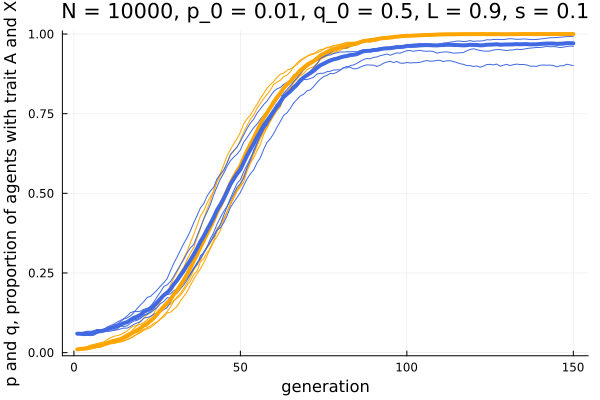

In [5]:
biased_transmission(N = 10^4, r_max = 5, t_max = 150, p_0 = 0.01, q_0 = 0.5, L = 0.9, s = 0.1)

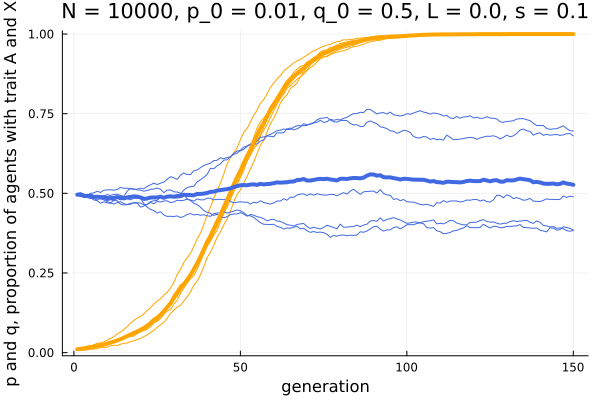

In [6]:
biased_transmission(N = 10^4, r_max = 5, t_max = 150, p_0 = 0.01, q_0 = 0.5, L = 0.0, s = 0.1)

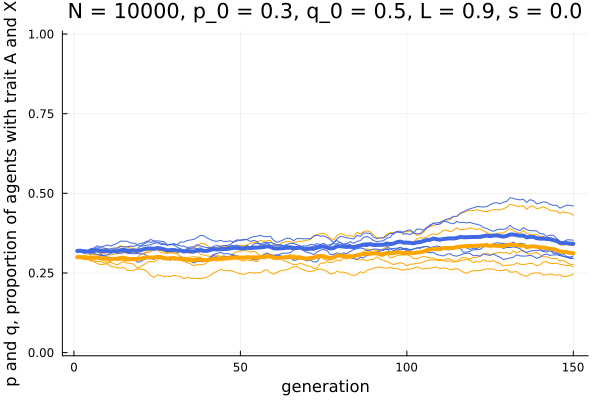

In [7]:
biased_transmission(N = 10^4, r_max = 5, t_max = 150, p_0 = 0.3, q_0 = 0.5, L = 0.9, s = 0.0)